# MNIST Digit Classification with Convolutional Neural Network (CNN)

**Discipline(s):** Computer Vision, Deep Learning

colab에서 돌릴 경우, 런타임 유형을 GPU로 변경해주세요.

## 1. Import Statements

---



In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

## 2. Data Preprocessing

---



The first step is to preprocess our data.

In [9]:
BATCH_SIZE = 32 # 64, 128 사용하면 더 빠른 학습 가능하지만 overfitting 가능성 존재
EPOCHS = 5 # MNIST classification 이라는 목적 고려, 학습 시간과 성능의 균형
LEARNING_RATE = 0.001 # Adam의 기본값, 너무 작으면 underfitting
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# 아래의 값 (0.1307, 0.3081) 이 나온 이유: train dataset 의 평균/표준편차

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 먼저 ToTensor만 적용
temp_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
temp_loader = DataLoader(temp_dataset, batch_size=60000, shuffle=False)

# 모든 픽셀을 모아서 평균/표준편차 계산
data_iter = iter(temp_loader)
images, _ = next(data_iter)
mean = images.mean().item()
std = images.std().item()

print(f"Mean: {mean:.4f}, Std: {std:.4f}")

Mean: 0.1307, Std: 0.3081


In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [12]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
X_train = train_dataset.data
y_train = train_dataset.targets
X_test = test_dataset.data
y_test = test_dataset.targets

print("Training Images:", X_train.shape)  # [60000, 28, 28]
print("Testing Images:", X_test.shape)    # [10000, 28, 28]
print("Training Labels:", y_train.shape)  # [60000]
print("Test Labels:", y_test.shape)       # [10000]

Training Images: torch.Size([60000, 28, 28])
Testing Images: torch.Size([10000, 28, 28])
Training Labels: torch.Size([60000])
Test Labels: torch.Size([10000])


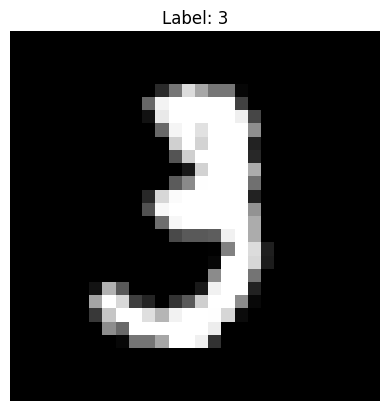

In [14]:
plt.imshow(X_train[10], cmap='gray')
plt.title(f"Label: {y_train[10].item()}")
plt.axis('off')
plt.show()

## 3. Convolutional Neural Network (CNN)

---



### 3.1. Define the Model

We then have to define our convolutional neural network.

In [15]:
# VGG style 로 설계!
# 동일한 kernel 크기 (3 * 3), padding을 통해 size 가 변하지 않음
# Conv -> ReLU -> Max pooling 으로 이어지는 구조
# FC layer 로 들어가기 전 flatten
# Spatial size ↓, Channel 수 ↑ 를 통해 더 복잡한 특징 표현

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),  # [B, 1, 28, 28] → [B, 16, 28, 28]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                                 # → [B, 16, 14, 14]

            nn.Conv2d(16, 32, kernel_size=3, padding=1),                           # → [B, 32, 14, 14]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                                                    # → [B, 32, 7, 7]

            nn.Flatten(),                                                         # → [B, 1568]
            nn.Linear(32*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)                                                    # → [B, 10] # 10: class 개수
        )

    def forward(self, x):
        return self.net(x)

In [16]:
# 모델 준비
model = SimpleCNN().to(DEVICE)

Once our model is defined, we can compile it using the Adam optimizer and the categorical cross-entropy loss function.

In [18]:
criterion = nn.CrossEntropyLoss() # 분류 문제기 때문에
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### 3.2. Train the Model

In [19]:
def train(model, loader):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y.size(0)
        correct += (output.argmax(dim=1) == y).sum().item()
        total += y.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [20]:
def evaluate(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            output = model(x)
            loss = criterion(output, y)

            total_loss += loss.item() * y.size(0)
            correct += (output.argmax(dim=1) == y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [21]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader)
    test_loss, test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"[Epoch {epoch+1}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

[Epoch 1] Train Loss: 0.1347, Train Acc: 0.9590 | Test Loss: 0.0575, Test Acc: 0.9816
[Epoch 2] Train Loss: 0.0449, Train Acc: 0.9859 | Test Loss: 0.0343, Test Acc: 0.9883
[Epoch 3] Train Loss: 0.0306, Train Acc: 0.9902 | Test Loss: 0.0517, Test Acc: 0.9834
[Epoch 4] Train Loss: 0.0228, Train Acc: 0.9928 | Test Loss: 0.0427, Test Acc: 0.9863
[Epoch 5] Train Loss: 0.0169, Train Acc: 0.9943 | Test Loss: 0.0318, Test Acc: 0.9901


### 3.3. 시각화

Finally, we can plot the curves.

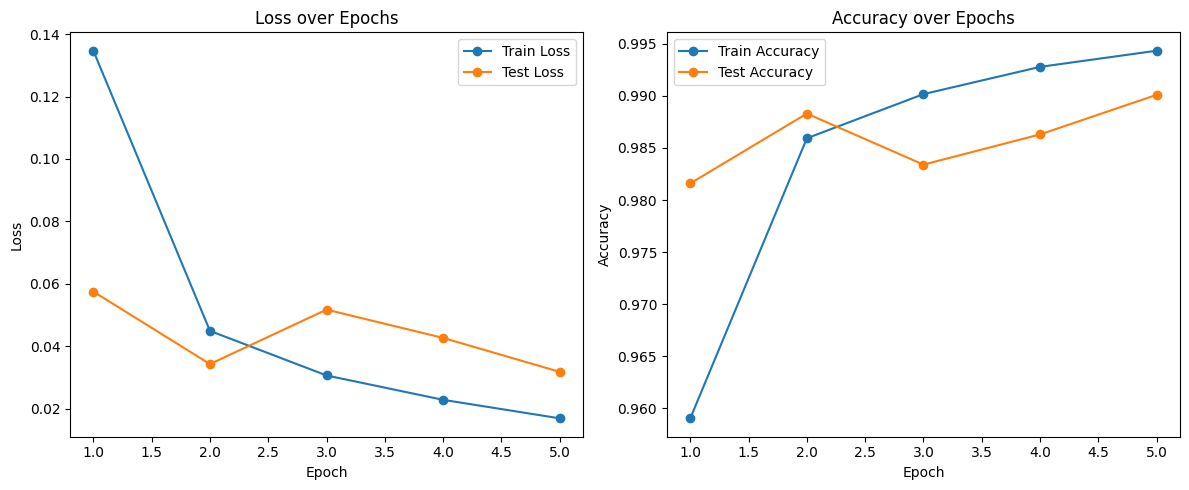

In [22]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

## 4. Make a Prediction

---



Once our model is trained, we can use it to make predictions. To do this, we first use our test set to predict the classes.

In [23]:
def show_random_predictions(model, dataset, num_images=5):
    model.eval()

    indices = random.sample(range(len(dataset)), num_images)
    images = torch.stack([dataset[i][0] for i in indices])
    labels = torch.tensor([dataset[i][1] for i in indices])

    images = images.to(DEVICE)
    outputs = model(images)
    preds = outputs.argmax(dim=1)

    plt.figure(figsize=(12, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title(f"GT: {labels[i].item()}\nPred: {preds[i].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Finally, we can show a random test image with its corresponding prediction.

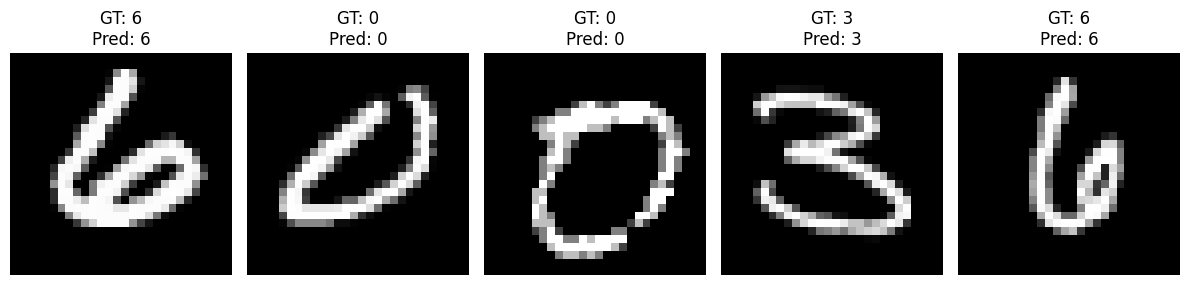

In [24]:
show_random_predictions(model, test_dataset, num_images=5)

## ResNet

In [25]:
# 위와 동일하게 설정

BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # 크기가 그대로 유지되도록 padding = 1, kernel_size = 3 사용
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        # batchnorm 추가 (Resnet)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # channel 수가 다를 때, identity 를 단순히 더해줄 수 없으므로, 1 * 1 conv 사용, kenel 의 parameter 는 학습
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)

        # 그냥 nn.Sequential 을 해주면 안될까? 추후에 바꿔볼 것!
        out = self.conv(x)
        out = self.bn(out)
        out += identity
        return self.relu(out)

In [27]:
class ResNetLike(nn.Module):
    def __init__(self):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 28x28 → 14x14
        )

        self.layer1 = ResidualBlock(16, 32)   # → [B, 32, 14, 14]
        self.layer2 = ResidualBlock(32, 64)   # → [B, 64, 14, 14]

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # → [B, 64, 1, 1]
        self.fc = nn.Linear(64, 10)  # 10 classes for MNIST

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)  # Flatten: [B, 64]
        return self.fc(x)

In [28]:
model = ResNetLike().to(DEVICE)

In [29]:
criterion = nn.CrossEntropyLoss() # 분류 문제기 때문에
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [30]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader)
    test_loss, test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"[Epoch {epoch+1}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

[Epoch 1] Train Loss: 0.4451, Train Acc: 0.8955 | Test Loss: 0.1267, Test Acc: 0.9648
[Epoch 2] Train Loss: 0.1153, Train Acc: 0.9686 | Test Loss: 0.1149, Test Acc: 0.9665
[Epoch 3] Train Loss: 0.0853, Train Acc: 0.9755 | Test Loss: 0.0802, Test Acc: 0.9757
[Epoch 4] Train Loss: 0.0727, Train Acc: 0.9790 | Test Loss: 0.0572, Test Acc: 0.9820
[Epoch 5] Train Loss: 0.0628, Train Acc: 0.9816 | Test Loss: 0.0554, Test Acc: 0.9828


### 시각화

Finally, we can plot the curves.

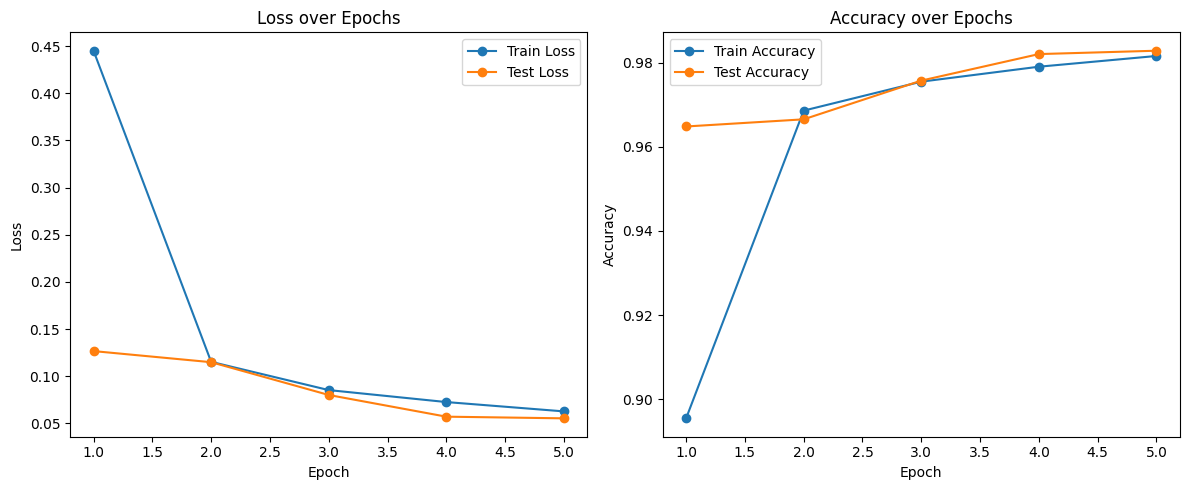

In [31]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

### Make a Prediction

---



Once our model is trained, we can use it to make predictions. To do this, we first use our test set to predict the classes.

In [32]:
def show_random_predictions(model, dataset, num_images=5):
    model.eval()

    indices = random.sample(range(len(dataset)), num_images)
    images = torch.stack([dataset[i][0] for i in indices])
    labels = torch.tensor([dataset[i][1] for i in indices])

    images = images.to(DEVICE)
    outputs = model(images)
    preds = outputs.argmax(dim=1)

    plt.figure(figsize=(12, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title(f"GT: {labels[i].item()}\nPred: {preds[i].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Finally, we can show a random test image with its corresponding prediction.

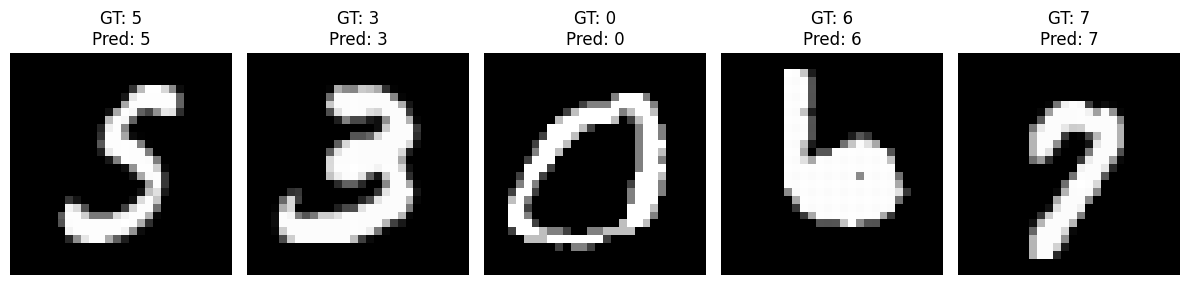

In [33]:
show_random_predictions(model, test_dataset, num_images=5)

# 다른 데이터셋으로도 진행해보기